In [2]:
import pandas as pd
import numpy as np


csv_path = "raw_data.csv"
df = pd.read_csv(csv_path)
for col in df.columns:
    print(col)

Time (s)
Latitude (°)
Longitude (°)
Altitude (m)
Altitude WGS84 (m)
Speed (m/s)
Direction (°)
Distance (km)
Horizontal Accuracy (m)
Vertical Accuracy (m)
Satellites


In [3]:
subset = df[["Latitude (°)", "Longitude (°)", "Altitude WGS84 (m)"]]
window = 5
smoothed = subset.rolling(window=window, center=True).mean()
smoothed = smoothed.dropna().reset_index(drop=True)
#print(subset.head())   # first 5 rows


In [4]:
a = 6378137.0          # semi-major axis [m]
f = 1 / 298.257223563  # flattening
e2 = f * (2 - f)       # eccentricity squared

def geodetic_to_ecef(lat_deg, lon_deg, h):
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)

    N = a / np.sqrt(1 - e2 * np.sin(lat)**2)

    x = (N + h) * np.cos(lat) * np.cos(lon)
    y = (N + h) * np.cos(lat) * np.sin(lon)
    z = (N * (1 - e2) + h) * np.sin(lat)
    return np.array([x, y, z])

ecef = np.vstack(subset.apply(
    lambda row: geodetic_to_ecef(row["Latitude (°)"], row["Longitude (°)"], row["Altitude WGS84 (m)"]),
    axis=1
))
#print(ecef)

In [5]:
def ecef_to_enu_matrix(lat_deg, lon_deg):
    lat = np.radians(lat_deg)
    lon = np.radians(lon_deg)

    # rotation from ECEF to ENU
    R = np.array([
        [-np.sin(lon),             np.cos(lon),              0],
        [-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
        [ np.cos(lat)*np.cos(lon),  np.cos(lat)*np.sin(lon), np.sin(lat)]
    ])
    return R

In [6]:
enu = []

for i in range(1, len(ecef)):
    ref_lat = subset.iloc[i-1]["Latitude (°)"]
    ref_lon = subset.iloc[i-1]["Longitude (°)"]
    ref_ecef = ecef[i-1]

    diff = ecef[i] - ref_ecef
    R = ecef_to_enu_matrix(ref_lat, ref_lon)
    enu_vec = R @ diff
    enu.append(enu_vec)

enu = np.vstack(enu)


#print(enu)



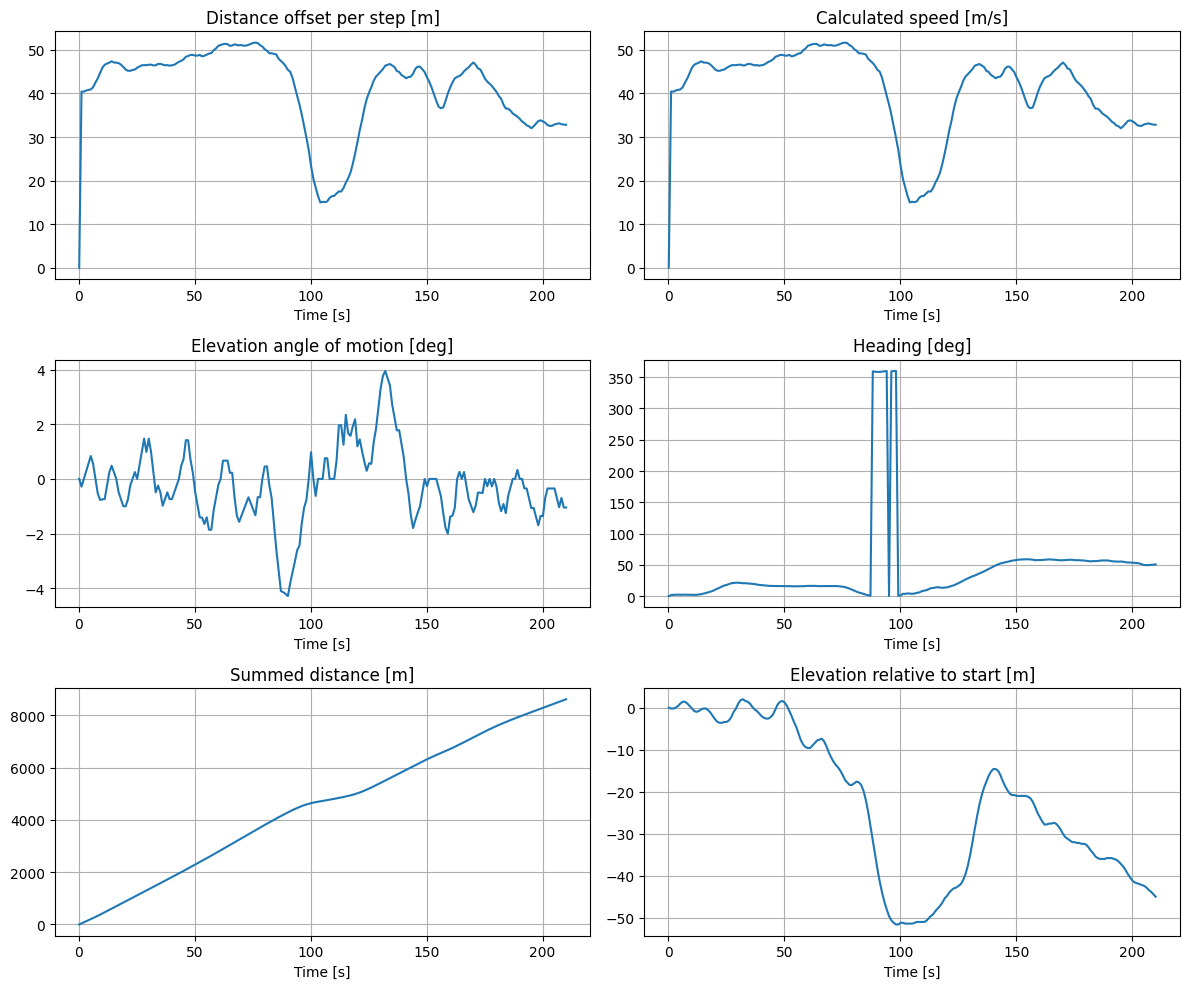

In [7]:
import matplotlib.pyplot as plt


# Recalculate ECEF from smoothed lat/lon/alt
ecef = np.vstack(smoothed.apply(
    lambda row: geodetic_to_ecef(
        row["Latitude (°)"], row["Longitude (°)"], row["Altitude WGS84 (m)"]),
    axis=1
))

# Recalculate ENU displacements
enu = []
for i in range(1, len(ecef)):
    ref_lat = smoothed.iloc[i-1]["Latitude (°)"]
    ref_lon = smoothed.iloc[i-1]["Longitude (°)"]
    diff = ecef[i] - ecef[i-1]
    R = ecef_to_enu_matrix(ref_lat, ref_lon)
    enu_vec = R @ diff
    enu.append(enu_vec)
enu = np.vstack([[0,0,0], enu])  # pad with zero for first row

# Use time aligned with smoothed data
time = df.loc[smoothed.index, "Time (s)"].to_numpy()

# --- Calculations ---
delta_d = np.linalg.norm(enu, axis=1)                 # distance offset [m]
delta_t = np.diff(time, prepend=time[0])              # dt [s]
speed = np.divide(delta_d, delta_t, out=np.zeros_like(delta_d), where=delta_t>0)

elev_angle = np.degrees(np.arctan2(enu[:,2], np.linalg.norm(enu[:,:2], axis=1)))
heading = (np.degrees(np.arctan2(enu[:,0], enu[:,1])) + 360) % 360

summed_dist = np.cumsum(delta_d)
summed_elev = smoothed["Altitude WGS84 (m)"].to_numpy() - smoothed["Altitude WGS84 (m)"].iloc[0]

# --- Plot ---
fig, axs = plt.subplots(3, 2, figsize=(12,10))
axs = axs.ravel()

axs[0].plot(time, delta_d)
axs[0].set_title("Distance offset per step [m]")

axs[1].plot(time, speed)
axs[1].set_title("Calculated speed [m/s]")

axs[2].plot(time, elev_angle)
axs[2].set_title("Elevation angle of motion [deg]")

axs[3].plot(time, heading)
axs[3].set_title("Heading [deg]")

axs[4].plot(time, summed_dist)
axs[4].set_title("Summed distance [m]")

axs[5].plot(time, summed_elev)
axs[5].set_title("Elevation relative to start [m]")

for ax in axs:
    ax.set_xlabel("Time [s]")
    ax.grid(True)

plt.tight_layout()
plt.show()

Mean difference: 0.43127962085308
Std deviation: 2.1523860390619225
Max difference: 7.400000000000006
Min difference: -6.800000000000011


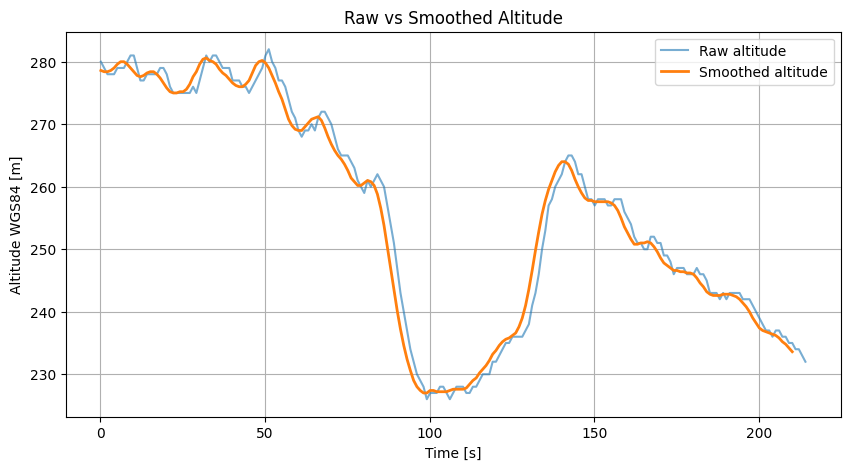

In [8]:
raw_alt = df["Altitude WGS84 (m)"].to_numpy()
smoothed_alt = smoothed["Altitude WGS84 (m)"].to_numpy()
time_raw = df["Time (s)"].to_numpy()
time_smooth = df.loc[smoothed.index, "Time (s)"].to_numpy()
raw_alt_aligned = df.loc[smoothed.index, "Altitude WGS84 (m)"].to_numpy()

alt_diff = raw_alt_aligned - smoothed_alt

print("Mean difference:", alt_diff.mean())
print("Std deviation:", alt_diff.std())
print("Max difference:", alt_diff.max())
print("Min difference:", alt_diff.min())


plt.figure(figsize=(10,5))
plt.plot(time_raw, raw_alt, label="Raw altitude", alpha=0.6)
plt.plot(time_smooth, smoothed_alt, label="Smoothed altitude", linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("Altitude WGS84 [m]")
plt.title("Raw vs Smoothed Altitude")
plt.legend()
plt.grid(True)
plt.show()


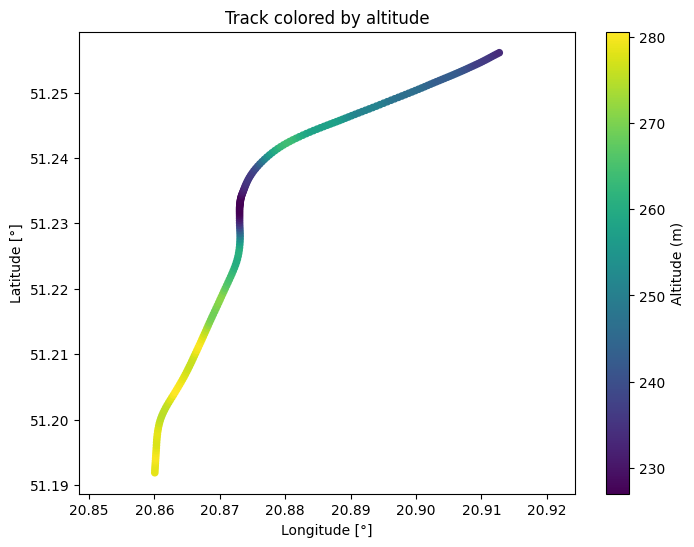

In [9]:
import matplotlib.pyplot as plt

# lat/lon from smoothed (or raw if you prefer)
lats = smoothed["Latitude (°)"].to_numpy()
lons = smoothed["Longitude (°)"].to_numpy()
alts = smoothed["Altitude WGS84 (m)"].to_numpy()

plt.figure(figsize=(8,6))
sc = plt.scatter(lons, lats, c=alts, cmap="viridis", s=20)
plt.colorbar(sc, label="Altitude (m)")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.title("Track colored by altitude")
plt.axis("equal")
plt.show()

In [10]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# get center of track
center = [lats.mean(), lons.mean()]

m = folium.Map(location=center, zoom_start=15, tiles="OpenStreetMap")


# colormap
norm = colors.Normalize(vmin=alts.min(), vmax=alts.max())
cmap = cm.ScalarMappable(norm=norm, cmap="viridis")

# add track segments with color
for i in range(1, len(lats)):
    color = colors.to_hex(cmap.to_rgba(alts[i]))
    folium.PolyLine(
        [(lats[i-1], lons[i-1]), (lats[i], lons[i])],
        color=color, weight=20, opacity=0.8
    ).add_to(m)

m.save("track_colored.html")

In [11]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Lat, Lon, and motion_angle must already exist
lats = smoothed["Latitude (°)"].to_numpy()
lons = smoothed["Longitude (°)"].to_numpy()

# compute slope angle if not already done
dE = enu[:,0]
dN = enu[:,1]
dU = enu[:,2]
dH = np.sqrt(dE**2 + dN**2)
motion_angle = np.degrees(np.arctan2(dU, dH))  # degrees

# normalize colors between min/max slope
norm = colors.Normalize(vmin=motion_angle.min(), vmax=motion_angle.max())
cmap = cm.ScalarMappable(norm=norm, cmap="coolwarm")

# base map centered at track
m = folium.Map(location=[lats.mean(), lons.mean()], zoom_start=15)

# add colored segments
for i in range(1, len(lats)):
    color = colors.to_hex(cmap.to_rgba(motion_angle[i]))
    folium.PolyLine(
        [(lats[i-1], lons[i-1]), (lats[i], lons[i])],
        color=color, weight=20, opacity=1
    ).add_to(m)

# save to file
m.save("track_slope_map.html")
print("Map saved → track_slope_map.html")

Map saved → track_slope_map.html


In [17]:
from scipy.interpolate import interp1d

# Original smoothed arrays
time_smooth = df.loc[smoothed.index, "Time (s)"].to_numpy()
lats = smoothed["Latitude (°)"].to_numpy()
lons = smoothed["Longitude (°)"].to_numpy()
alts = smoothed["Altitude WGS84 (m)"].to_numpy()

# New finer time grid (0.5s step instead of ~1s)
time_new = np.arange(time_smooth.min(), time_smooth.max(), 0.5)

# Build interpolators
lat_interp = interp1d(time_smooth, lats, kind="linear")
lon_interp = interp1d(time_smooth, lons, kind="linear")
alt_interp = interp1d(time_smooth, alts, kind="linear")

# Evaluate
lats_i = lat_interp(time_new)
lons_i = lon_interp(time_new)
alts_i = alt_interp(time_new)

ecef_i = np.vstack([
    geodetic_to_ecef(lat, lon, alt)
    for lat, lon, alt in zip(lats_i, lons_i, alts_i)
])

enu_i = []
for i in range(1, len(ecef_i)):
    R = ecef_to_enu_matrix(lats_i[i-1], lons_i[i-1])
    diff = ecef_i[i] - ecef_i[i-1]
    enu_i.append(R @ diff)
enu_i = np.vstack([[0,0,0], enu_i])

dE, dN, dU = enu_i[:,0], enu_i[:,1], enu_i[:,2]
dH = np.sqrt(dE**2 + dN**2)
motion_angle_i = np.degrees(np.arctan2(dU, dH))

import folium, matplotlib.cm as cm, matplotlib.colors as colors

norm = colors.Normalize(vmin=motion_angle_i.min(), vmax=motion_angle_i.max())
cmap = cm.ScalarMappable(norm=norm, cmap="coolwarm")

m = folium.Map(location=[lats_i.mean(), lons_i.mean()],
               zoom_start=13, zoom_control=False,   # hide the +/– buttons
    dragging=False,       # disable mouse dragging
)

for i in range(1, len(lats_i)):
    color = colors.to_hex(cmap.to_rgba(motion_angle_i[i]))
    folium.PolyLine(
        [(lats_i[i-1], lons_i[i-1]), (lats_i[i], lons_i[i])],
        color=color, weight=20, opacity=0.2
    ).add_to(m)

m.options["scrollWheelZoom"] = False
m.options["doubleClickZoom"] = False
m.options["touchZoom"] = False

m.save("track_slope_interp.html")
print("Map saved → track_slope_interp.html")

m


Map saved → track_slope_interp.html
